Autor: José Verdú-Díaz

La herramienta inferior forma parte de poly2pix, disponible aquí: https://github.com/Jose-Verdu-Diaz/sa_poly2pixel
___

Cargamos las librerías necesarias

In [114]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Cargamos la imágen de prueba

In [115]:
path = '../../projects/RM1/img/0001-0045.jpg'

if os.path.isfile(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
else:
    print (f'The file {path} does not exist.')

Mostramos la imagen junto a su histograma (eje y en escala logaritmica). Se pueden ver claramente 3 picos, de izquierda a derecha: el fondo negro, el músculo gris oscuro y el tejido adiposo gris claro. Obsérvese que el fondo no es de un negro perfecto.

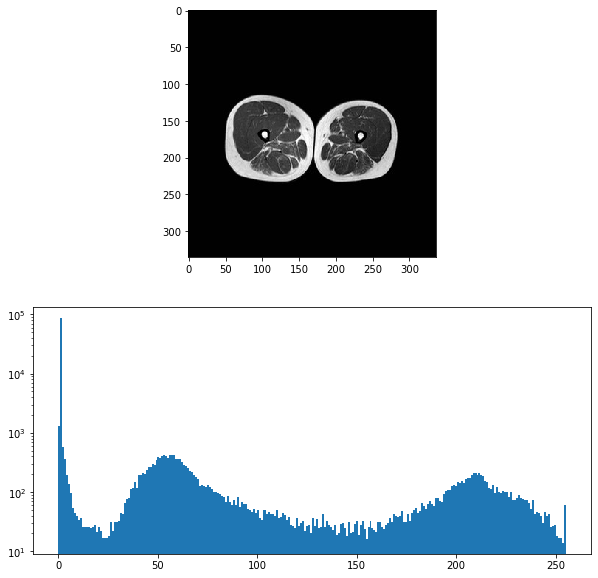

In [116]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
ax1.imshow(img, cmap='gray', interpolation='none');
ax2.hist(img.ravel(),256,[0,255]);
ax2.set_yscale('log')

Se aplica un threshold con un valor entre 20 y 100 (con aumentos de 5). Para encontrar el valor idóneo se realiza un barrido desde el límite inferior hasta encontrar únicamente 2 contornos. Además, se aplica una transformación morfológica para eliminar el ruido que pueda confundir al detector de contornos. El objetivo es conseguir una separación clara entre la pierna izquierda y derecha. Éste es el punto crítico donde este sistema puede fallar. Se muestra la imágen obtenida al aplicar el threshold.

Threshold: 55


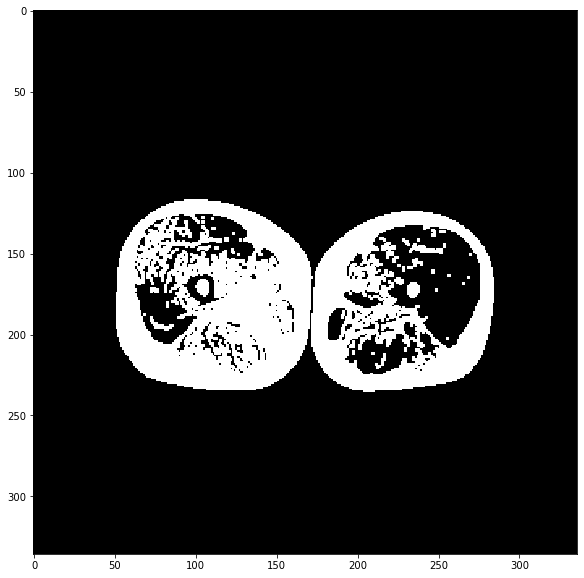

In [117]:
success = False
for th in np.arange(20, 101, 5).tolist():
    ret, thresh = cv2.threshold(img,th,255,cv2.THRESH_BINARY)

    # Remove white noise in mask
    kernel = np.ones((2,2),np.uint8)
    thresh = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1) 
              
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours)==2:                      
        success = True
        print(f'Threshold: {th}')
        break
if not success:
    print(f'{len(contours)} found at max threshold')

fig, ax = plt.subplots(figsize=(10, 10));
ax.imshow(thresh, cmap='gray', interpolation='none');

Detectamos los contornos externos (cv2.RETR_EXTERNAL) y calculamos los centroides de cada contorno. Los representamos en azul (pierna derecha) y rojo (pierna izquierda). Podemos distinguir entre izquierda y derecha a partir de la coordenada X de los centroides.

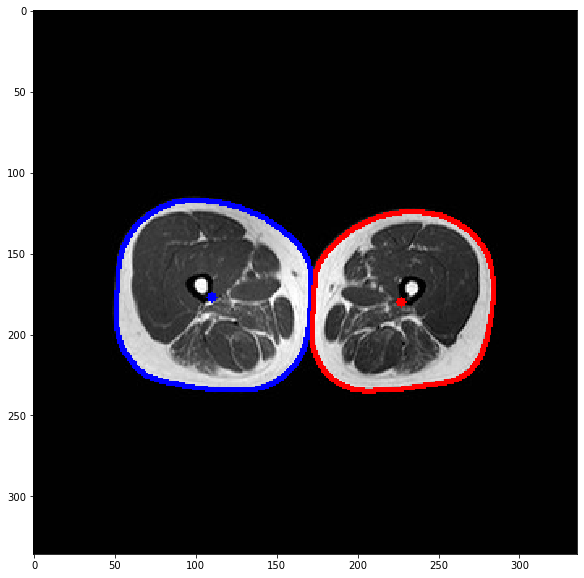

In [118]:
    # Imágenes RGB para la representación de los contornos y centroides
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Cetro del contorno
    centroids = []
    for i,c in enumerate(contours):
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append((cX,cY))
    
    if not len(centroids) == 2:
        print(f'Len of centroids is {len(centroids)}')
    else:
        # Derecha: Azul
        # Izquierda: Rojo
            if centroids[0][0] > centroids[1][0]:
                cv2.drawContours(img_rgb, [contours[1]], -1, (0, 0, 255), 2)
                cv2.drawContours(img_rgb, [contours[0]], -1, (255, 0, 0), 2)
                cv2.circle(img_rgb, centroids[1], 3, (0, 0, 255), -1)
                cv2.circle(img_rgb, centroids[0], 3, (255, 0, 0), -1)
    
            elif centroids[0][0] < centroids[1][0]:
                cv2.drawContours(img_rgb, [contours[0]], -1, (0, 0, 255), 2)
                cv2.drawContours(img_rgb, [contours[1]], -1, (255, 0, 0), 2)
                cv2.circle(img_rgb, centroids[0], 3, (0, 0, 255), -1)
                cv2.circle(img_rgb, centroids[1], 3, (255, 0, 0), -1)
                
            else: cv2.circle(img_rgb, (cX, cY), 3, (0, 255, 0), -1)
    
    fig, ax = plt.subplots(figsize=(10, 10));
    ax.imshow(img_rgb, cmap='gray', interpolation='none');

Generamos un fondo negro con las mismas dimensiones de la imágen.

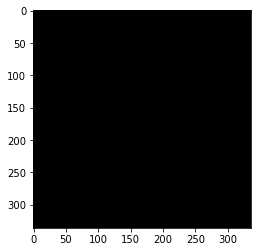

In [119]:
background = np.zeros(img.shape, np.uint8)
plt.imshow(background, cmap='gray', interpolation='none')
plt.show()

Obtenemos las máscaras a partir de los contornos y las aplicamos sobre la imágen original. Obtenemos imágenes, cada una con una pierna distinta.

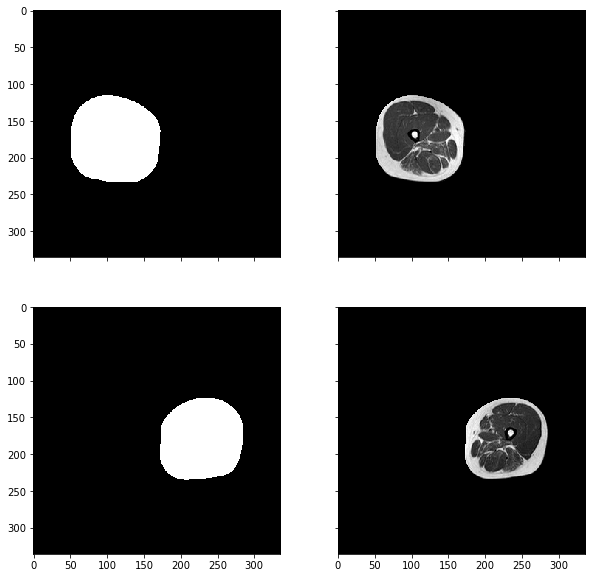

In [120]:
if centroids[0][0] > centroids[1][0]:
    mask_L = cv2.drawContours(background.copy(), [contours[1]], -1, 255, -1)
    mask_R = cv2.drawContours(background.copy(), [contours[0]], -1, 255, -1)

elif centroids[0][0] < centroids[1][0]:
    mask_L = cv2.drawContours(background.copy(), [contours[0]], -1, 255, -1)
    mask_R = cv2.drawContours(background.copy(), [contours[1]], -1, 255, -1)

else: pass

img_L = cv2.bitwise_and(img,img,mask = mask_L)
img_R = cv2.bitwise_and(img,img,mask = mask_R)

fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].imshow(mask_L, cmap='gray', interpolation='none');
axs[1,0].imshow(mask_R, cmap='gray', interpolation='none');
axs[0,1].imshow(img_L, cmap='gray', interpolation='none');
axs[1,1].imshow(img_R, cmap='gray', interpolation='none');

for ax in fig.get_axes(): ax.label_outer()

Encontramos la "bounding box" de cada pierna y recortamos las imágenes a sus dimensiones. Además volteamos la pierna izquierda: ahora solo existen piernas derechas. Con ello reducimos a la mitad la cantidad de músculos, duplicamos la cantidad de imágenes y (en este caso) reducimos las dimensiones de las imágenes a más de la mitad.

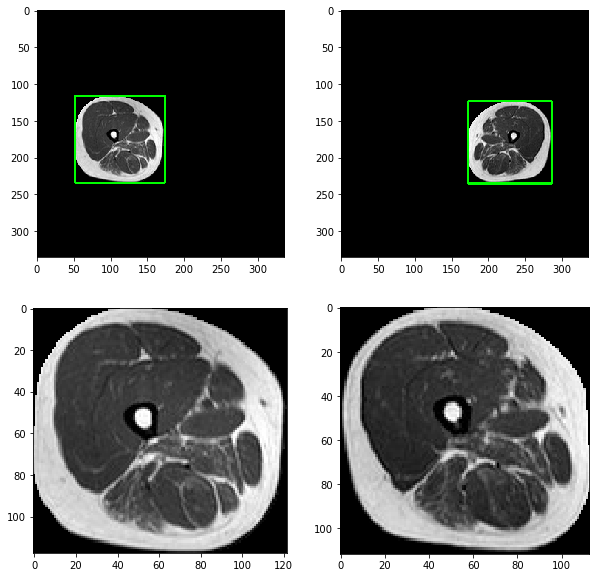

In [121]:
if centroids[0][0] > centroids[1][0]:
    x,y,w,h = cv2.boundingRect(contours[1])
    box_L = cv2.rectangle(cv2.cvtColor(img_L, cv2.COLOR_GRAY2BGR),(x,y),(x+w,y+h),(0,255,0),2)
    cropped_L = img_L[y:y+h, x:x+w]

    x,y,w,h = cv2.boundingRect(contours[0])
    box_R = cv2.rectangle(cv2.cvtColor(img_R, cv2.COLOR_GRAY2BGR),(x,y),(x+w,y+h),(0,255,0),2)
    cropped_R = cv2.flip(img_R[y:y+h, x:x+w], 1)

elif centroids[0][0] < centroids[1][0]:
    x,y,w,h = cv2.boundingRect(contours[0])
    box_L = cv2.rectangle(cv2.cvtColor(img_L, cv2.COLOR_GRAY2BGR),(x,y),(x+w,y+h),(0,255,0),2)
    cropped_L = img_L[y:y+h, x:x+w]

    x,y,w,h = cv2.boundingRect(contours[1])
    box_R = cv2.rectangle(cv2.cvtColor(img_R, cv2.COLOR_GRAY2BGR),(x,y),(x+w,y+h),(0,255,0),2)
    cropped_R = cv2.flip(img_R[y:y+h, x:x+w], 1)


fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].imshow(box_L, cmap='gray', interpolation='none');
axs[0,1].imshow(box_R, cmap='gray', interpolation='none');
axs[1,0].imshow(cropped_L, cmap='gray', interpolation='none');
axs[1,1].imshow(cropped_R, cmap='gray', interpolation='none');

El código se puede automatizar para procesar toda una carpeta con RMs de la siguiente manera:

In [ ]:
            if not os.path.exists(f'dir/L'):
                os.makedirs(f'dir/L')
            if not os.path.exists(f'dir/R'):
                os.makedirs(f'dir/R')

            for file in sorted(os.listdir(f'dir/img')):
        
                img = cv2.imread(f'dir/img/{file}', cv2.IMREAD_GRAYSCALE)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                centroids = []

                success = False
                for th in np.arange(20, 101, 5).tolist():
                    ret, thresh = cv2.threshold(img,th,255,cv2.THRESH_BINARY)    

                    # Remove white noise in mask
                    kernel = np.ones((2,2),np.uint8)
                    thresh = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1) 

                    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    
                    if len(contours)==2:                      
                        success = True
                        break

                if not success:
                    print(f'{bcolors.FAIL}ERROR ## {file} ## {len(contours)} contours{bcolors.ENDC}')
                    continue

                for i,c in enumerate(contours):
                    M = cv2.moments(c)
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    centroids.append((cX,cY))
                
                if len(centroids) > 2 or len(centroids) == 0:
                    print(f'Len of centroids is {len(centroids)}')
                else:
                    # Derecha: Azul
                    # Izquierda: Rojo
                        if centroids[0][0] > centroids[1][0]:
                            cv2.drawContours(img_rgb, [contours[1]], -1, (0, 0, 255), 2)
                            cv2.drawContours(img_rgb, [contours[0]], -1, (255, 0, 0), 2)
                            cv2.circle(img_rgb, centroids[1], 3, (0, 0, 255), -1)
                            cv2.circle(img_rgb, centroids[0], 3, (255, 0, 0), -1)
                
                        elif centroids[0][0] < centroids[1][0]:
                            cv2.drawContours(img_rgb, [contours[0]], -1, (0, 0, 255), 2)
                            cv2.drawContours(img_rgb, [contours[1]], -1, (255, 0, 0), 2)
                            cv2.circle(img_rgb, centroids[0], 3, (0, 0, 255), -1)
                            cv2.circle(img_rgb, centroids[1], 3, (255, 0, 0), -1)
                            
                        else: cv2.circle(img_rgb, (cX, cY), 3, (0, 255, 0), -1)

                background = np.zeros(img.shape, np.uint8)

                if centroids[0][0] > centroids[1][0]:
                    mask_L = cv2.drawContours(background.copy(), [contours[1]], -1, 255, -1)
                    mask_R = cv2.drawContours(background.copy(), [contours[0]], -1, 255, -1)

                elif centroids[0][0] < centroids[1][0]:
                    mask_L = cv2.drawContours(background.copy(), [contours[0]], -1, 255, -1)
                    mask_R = cv2.drawContours(background.copy(), [contours[1]], -1, 255, -1)

                else: pass

                img_L = cv2.bitwise_and(img,img,mask = mask_L)
                img_R = cv2.bitwise_and(img,img,mask = mask_R)

                if centroids[0][0] > centroids[1][0]:
                    x,y,w,h = cv2.boundingRect(contours[1])
                    box_L = cv2.rectangle(cv2.cvtColor(img_L, cv2.COLOR_GRAY2BGR),(x,y),(x+w,y+h),(0,255,0),2)
                    cropped_L = img_L[y:y+h, x:x+w]

                    x,y,w,h = cv2.boundingRect(contours[0])
                    box_R = cv2.rectangle(cv2.cvtColor(img_R, cv2.COLOR_GRAY2BGR),(x,y),(x+w,y+h),(0,255,0),2)
                    cropped_R = cv2.flip(img_R[y:y+h, x:x+w], 1)

                elif centroids[0][0] < centroids[1][0]:
                    x,y,w,h = cv2.boundingRect(contours[0])
                    box_L = cv2.rectangle(cv2.cvtColor(img_L, cv2.COLOR_GRAY2BGR),(x,y),(x+w,y+h),(0,255,0),2)
                    cropped_L = img_L[y:y+h, x:x+w]

                    x,y,w,h = cv2.boundingRect(contours[1])
                    box_R = cv2.rectangle(cv2.cvtColor(img_R, cv2.COLOR_GRAY2BGR),(x,y),(x+w,y+h),(0,255,0),2)
                    cropped_R = cv2.flip(img_R[y:y+h, x:x+w], 1)

                cv2.imwrite(f'dir/L/{file.strip(".jpg")}_L.jpg', cropped_L, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
                cv2.imwrite(f'dir/R/{file.strip(".jpg")}_R.jpg', cropped_R, [int(cv2.IMWRITE_JPEG_QUALITY), 100])